# Imports

In [1]:
from random import random

import torch
import torch.nn as nn

from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
%matplotlib inline

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Pytorch version:", torch.__version__)

Device: cuda:0
Pytorch version: 1.13.1+cu116


# Parmaeters

In [3]:
EPOCHS = 20
LEARNING_RATE = 0.001
WEIGHT_DECAY = 5e-5
IMAGES_SIZE = 32
VAL_SPLIT_SIZE = 0.1
BATCH_SIZE = 128
SCHEDULAR_GAMMA = 0.98
SCHEDULAR_STEP_SIZE = 1
DATASET_PATH = "./data"

# Dataset

In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Transforms

In [5]:
train_transforms = transforms.Compose([
    transforms.Resize((IMAGES_SIZE, IMAGES_SIZE)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMAGES_SIZE, IMAGES_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

inv_normalize = lambda x : x / 2 + 0.5

## Create Data Loader

In [6]:
train_data = CIFAR10(root=DATASET_PATH, train=True, download=True, transform=train_transforms)
test_data = CIFAR10(root=DATASET_PATH, train=True, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
train_size = int((1-VAL_SPLIT_SIZE) * len(train_data))
val_size = len(train_data) - train_size
train_split, val_split = torch.utils.data.random_split(train_data, [train_size, val_size])

In [8]:
train_loader = torch.utils.data.DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

## Show

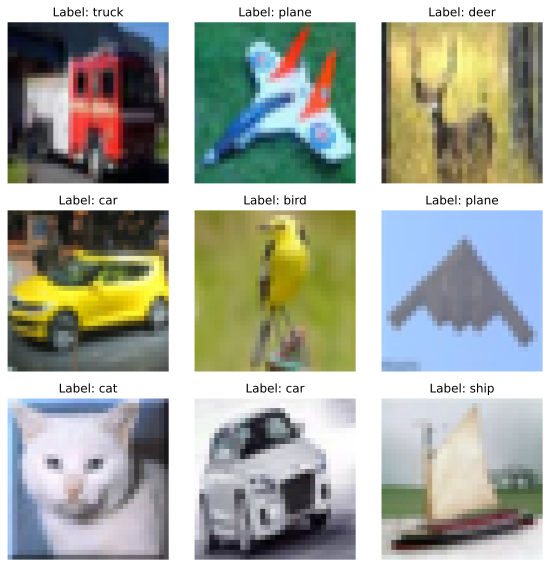

In [9]:
fig = plt.figure(figsize=(8, 8))
for i in range(9):
    rand_idx = int(random() * len(test_data))
    img = test_data[rand_idx][0]
    img = inv_normalize(img)  # unnormalize
    fig.add_subplot(3, 3, i+1)
    plt.title(f"Label: {classes[test_data[rand_idx][1]]}")
    plt.axis('off')
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
plt.tight_layout()
plt.show()

# Functions

## Early Stopping

In [10]:
class EarlyStopping:
    def __init__(self):
        self.min_validation_loss = np.inf
        self.counter = 0

    def check(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + 0.05):
            self.counter += 1
            if self.counter >= 1:
                return True
        return False

## Test Fucntion

In [11]:
@torch.no_grad()
def test(model, test_loader, loss_function=None):
    accuracy = 0
    total = 0
    running_loss = 0
    for (images, labels) in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(images)
        if loss_function is not None:
            loss = loss_function(outputs, labels)
            running_loss += loss.item()
        _, predicts = torch.max(outputs.data, 1)
        accuracy += (predicts == labels).sum().item()
        total += labels.size(0)
    res = [(accuracy / total * 100.)]
    if loss_function is not None:
        res += [(running_loss/len(test_loader))]
    return res

## Train functions

In [12]:
def train(model, train_loader, validation_loader, optimizer, loss_function, scheduler, epochs):
    losses = []
    val_losses = []
    accuracies = []
    val_accuracies = []
    best_accuracy = 0
    total_time_train = 0
    early_stopping = EarlyStopping()
    for epoch in range(epochs):
        running_loss = 0
        accuracy = 0
        total_size = 0
        for batch, (images, labels) in enumerate(train_loader):
            # move to target device (gpu)
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            # predict
            model.zero_grad()
            outputs = model(images)
            # cal accuracy
            _, predicts = torch.max(outputs.data, 1)
            accuracy += (predicts == labels).sum().item()
            total_size += labels.size(0)
            # cal loss
            loss = loss_function(outputs, labels)
            loss.backward()
            # optimizer step
            optimizer.step()
            # update progress bar
            running_loss += loss.item()
            print(f"\repoch {epoch+1}: loss={running_loss/(batch+1):>.4f}", end=" ")

        # append to history
        accuracies.append(accuracy / total_size * 100.)
        losses.append(running_loss / len(train_loader))

        # scheduler
        scheduler.step()

        # test validation data
        val_accuracy, val_loss = test(model, validation_loader, loss_function)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
    
        # early stop
        if early_stopping.check(val_loss):
            print(f"- accuracy={accuracies[-1]:>.4f}% - val_loss={val_losses[-1]:>.4f} - val_accuracy={val_accuracies[-1]:>.4f}%")
            print("-----------\n Early stop!")
            return {"loss": losses, "val_loss": val_losses, "accuracy": accuracies, "val_accuracy": val_accuracies}
        
        # step progress_bar
        addition_output = f"loss = {losses[-1]:>.4f} - accuracy = {accuracies[-1]:>.4f}% - val_loss = {val_losses[-1]:>.4f} - val_accuracy: {val_accuracies[-1]:>.4f}%"
        print(f"- accuracy={accuracies[-1]:>.4f}% - val_loss={val_losses[-1]:>.4f} - val_accuracy={val_accuracies[-1]:>.4f}%")

    return {"loss": losses, "val_loss": val_losses, "accuracy": accuracies, "val_accuracy": val_accuracies}

## Show Predicts Samples

In [13]:
@torch.no_grad()
def show_predicts(model, test_data, n_test=5):
    fig, ax = plt.subplots(2, n_test, figsize=(12, 4))
    model.eval()
    for i in range(n_test):
        rand_index = int(random() * len(test_data))
        image = test_data[rand_index][0]
        img = inv_normalize(image)  # unnormalize
        predicts = model(image.unsqueeze(0).to(device))
        ax[0, i].set_title(f"actual = {classes[int(test_data[rand_index][1])]}")
        ax[0, i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        ax[0, i].axis(False)
        predicts = nn.functional.softmax(predicts, dim=-1)
        hbars = ax[1, i].barh(classes, predicts.cpu().numpy().flatten() * 100., align='center')
        ax[1, i].set_xlim([0, 100])
        fig.tight_layout()
    plt.show()

## Plot Metrics Function

In [14]:
def plot_metrics(history):
    fig, axes = plt.subplots(2, 1)
    axes[0].set_title("Loss")
    axes[0].plot(history["loss"], label="loss")
    axes[0].plot(history["val_loss"], label="val_loss")
    axes[0].legend()

    axes[1].set_title("Accuracy")
    axes[1].plot(history["accuracy"], label="accuracy")
    axes[1].plot(history["val_accuracy"], label="val_accuracy")
    axes[1].legend()
    
    plt.tight_layout(pad=2)
    plt.xlabel("epochs")
    plt.show()

# Create Model & Train

if using from colab or other server

In [15]:
!pip uninstall -y todels
!pip install git+https://github.com/Esmokes17/todels.git

Found existing installation: Todels 0.0.1
Uninstalling Todels-0.0.1:
  Successfully uninstalled Todels-0.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Esmokes17/todels.git to /tmp/pip-req-build-ugfqjhro
  Running command git clone --filter=blob:none --quiet https://github.com/Esmokes17/todels.git /tmp/pip-req-build-ugfqjhro
  Resolved https://github.com/Esmokes17/todels.git to commit 6f10391268553cabdca6ba6e19afd975ced954c9
  Preparing metadata (setup.py) ... done
  Created wheel for Todels: filename=Todels-0.0.1-py3-none-any.whl size=12502 sha256=68267fb407174bc26590829b99fdc4cb880ede4bf810b952c8dcf5bc437a9eb7
  Stored in directory: /tmp/pip-ephem-wheel-cache-uaj7yjzz/wheels/1c/5c/3d/93def4003934913e60da1bda9e4853b9296ef23a0e4f5bf6b7
Successfully built Todels


## Create Model

In [16]:
from todels.residual.resnet import Resnet18
torch.cuda.empty_cache()
model = Resnet18(len(classes))
model.fc = nn.Sequential(
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Dropout(0.2),
    nn.LazyLinear(len(classes)),
)
model = model.to(device)
# summary(model, (3, IMAGES_SIZE, IMAGES_SIZE), device="cuda")

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [17]:
torch.cuda.empty_cache()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=SCHEDULAR_STEP_SIZE, gamma=SCHEDULAR_GAMMA)
loss_fn = nn.CrossEntropyLoss().to(device)

## Train Model

In [18]:
history_resnet = train(model, train_loader, val_loader, optimizer, loss_fn, scheduler, EPOCHS)

epoch 1: loss=1.5514 - accuracy=43.8067% - val_loss=1.4075 - val_accuracy=50.3000%
epoch 2: loss=1.2496 - accuracy=55.3622% - val_loss=1.1866 - val_accuracy=58.0000%
epoch 3: loss=1.1062 - accuracy=60.8800% - val_loss=1.0474 - val_accuracy=62.6000%
epoch 4: loss=1.0069 - accuracy=64.3622% - val_loss=1.0163 - val_accuracy=64.7800%
epoch 5: loss=0.9430 - accuracy=67.1889% - val_loss=0.9498 - val_accuracy=66.2800%
epoch 6: loss=0.8808 - accuracy=69.1622% - val_loss=0.9054 - val_accuracy=68.8800%
epoch 7: loss=0.8387 - accuracy=70.7378% - val_loss=0.8556 - val_accuracy=70.6200%
epoch 8: loss=0.7951 - accuracy=72.1956% - val_loss=0.8391 - val_accuracy=71.1200%
epoch 9: loss=0.7612 - accuracy=73.4289% - val_loss=0.8047 - val_accuracy=71.2400%
epoch 10: loss=0.7236 - accuracy=74.8156% - val_loss=0.8091 - val_accuracy=71.4800%
epoch 11: loss=0.7005 - accuracy=75.6089% - val_loss=0.8006 - val_accuracy=72.5000%
epoch 12: loss=0.6793 - accuracy=76.4222% - val_loss=0.8151 - val_accuracy=73.0600%
e

## Plot Metrics

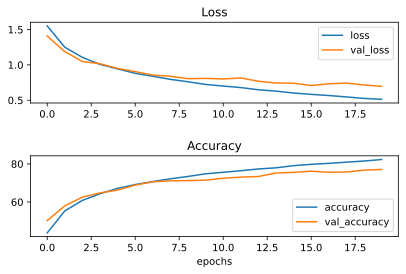

In [19]:
plot_metrics(history_resnet)

## Test

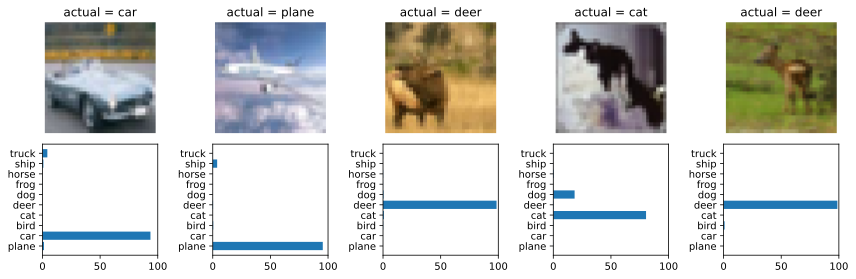

In [23]:
show_predicts(model, test_data)

In [21]:
accuracy, loss = test(model, test_loader, loss_fn)
print(f"accuracy = {accuracy:>.2f}%")
print(f"loss = {loss:>.2f}")

accuracy = 86.53%
loss = 0.39
